#  An analysis of the fundamental tone of a bell

In this notebook, we will look at the harmonic tuning of a 14th century bell. We will start by finding its fundamental tone and convert the audio signal to a chromagram representation in order to ease the visualization of the three characteristic notes of the bell.

## *Marie*, bell of the hours founded in 1376 by bell-founder Jehan Jouvente

The *Marie* bell is one of the three fixed clock bells of the cathédrale Saint-Etienne de Sens. Located in the campanile above the main tower of the cathedral with a diameter of 1.5 m and a weight of 1900 kg, this bell is used to strike the hours.

As a first step, we will load the audio file with python package [librosa](https://librosa.org/doc/latest/index.html) and implement a Fast Fourier Transform in order to find the fundamental tone of the bell while moving from time to frequency domain. 

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks

In [2]:
audio_file = "audio/marie.wav"

In [3]:
ipd.Audio(audio_file)

Let's load the audio file with *librosa.load()* function in order to analyze its samples and duration.

In [4]:
# loading audio file with librosa
signal, sr = librosa.load(audio_file, sr=44100)
sample_duration = 1 / sr
duration = sample_duration * len(signal)

print(f"""The audio file '{audio_file}' contains {signal.size} samples 
One sample is equal to : {sample_duration:.6f} seconds
\nDuration of the audio file : {sample_duration:.6f} * {signal.size} ~ {(sample_duration*signal.size):.2f} seconds""")

The audio file 'audio/marie.wav' contains 352800 samples 
One sample is equal to : 0.000023 seconds

Duration of the audio file : 0.000023 * 352800 ~ 8.00 seconds


## Visualizing the waveform

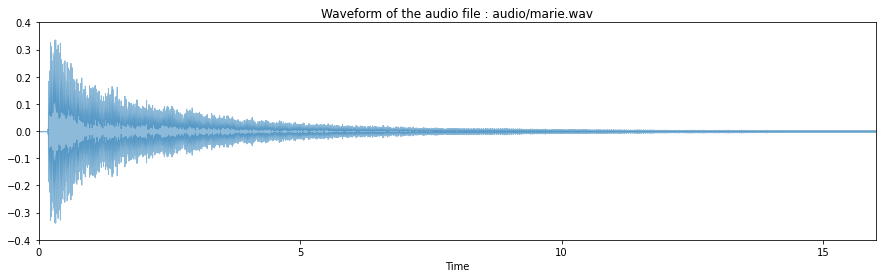

In [5]:
plt.figure(figsize=(15, 4))
plt.ylim(-0.4, 0.4)

librosa.display.waveplot(signal, alpha=0.5)
plt.title(f"Waveform of the audio file : {audio_file}")
plt.show()

## Finding the frequency of the fundamental tone

Secondly, we will identify the bell fundamental frequency using a Fast Fourier Transform, while moving the audio signal from time to frequency domain using the *numpy.fft.fft()* function.

In [6]:
signal_fft = np.fft.fft(signal)
magnitude = np.abs(signal_fft)
frequency = np.linspace(0, sr, len(magnitude))

We can finally use the *scipy.signal.find_peaks()* function to define the fundamental frequency of the bell which appears to correspond approximately to a **F#4 note** (367 Hz).

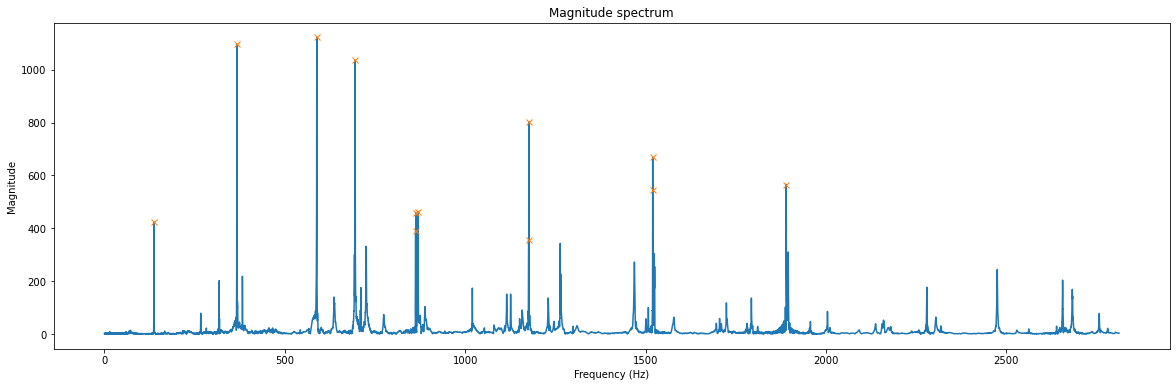

In [7]:
peaks, _ = find_peaks(magnitude[:22500], height=350)

plt.figure(figsize=(20, 6))
plt.plot(frequency[:22500], magnitude[:22500])
plt.plot(frequency[peaks], magnitude[peaks], "x")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude spectrum")
plt.show()

In [8]:
frequency[peaks][1]

367.00104025238164

## Hum note

However, when a bell is struck, the energy imparted causes vibration of the bell in a complex manner and a series of tones known as partials or harmonics are generated. While examining the partials of the bell *Marie*, it appeared that it wasn’t accurately tuned. For instance, to be accurately tuned, the [hum tone](https://en.wikipedia.org/wiki/Strike_tone) of a bell (the actual first partial) should normally be an octave below the fundamental tone but in that case, it was an eleventh below the fundamental tone, with a frequency of 136.9 Hz (i.e. **C#3 note**).

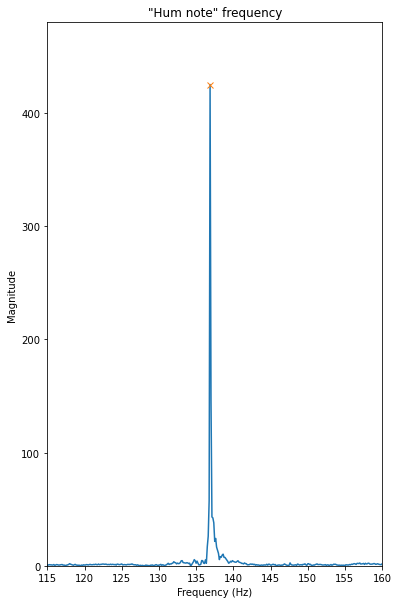

In [9]:
plt.figure(figsize=(6, 10))
plt.plot(frequency, magnitude)
plt.plot(frequency[peaks], magnitude[peaks], "x")
plt.axis([115, 160, 0, 480])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title('"Hum note" frequency')
plt.show()

## Converting the audio signal into a Chromagram representation

In order to ease the visualization of the fundamental tone and partials of the bell, we will first convert the audio signal into an original chromagram by using the **Constant-Q Transform** (log-frequency spectrogram) with the *librosa.feature.chroma_cqt()* function.

C:\Users\joachim\anaconda3\envs\sound\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


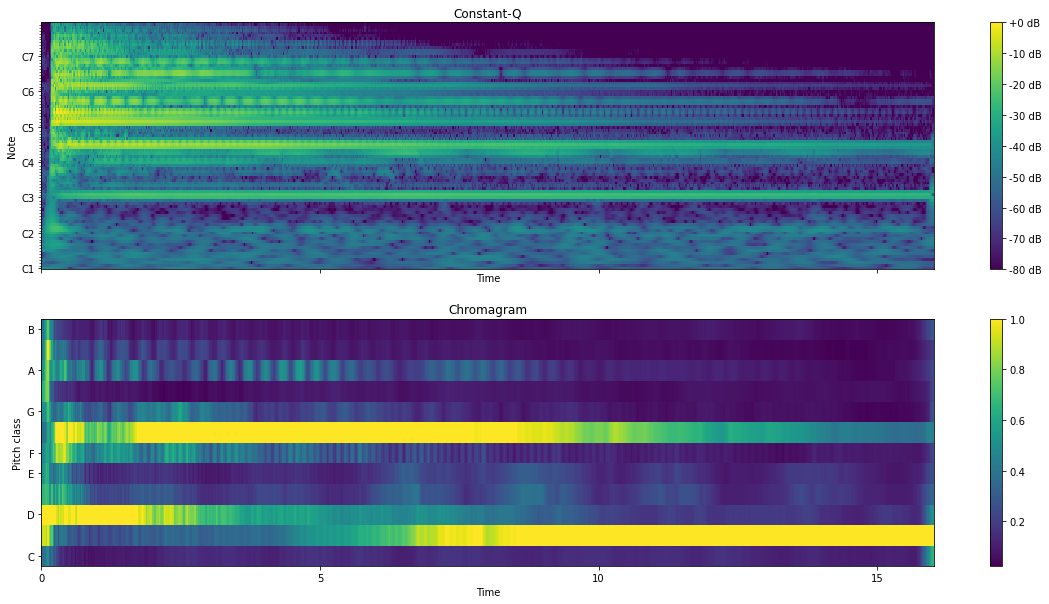

In [10]:
# chromagram 
chroma = librosa.feature.chroma_cqt(signal, sr=sr)

# constant-Q 
CQT = librosa.cqt(signal, sr=sr)
CQT_db = librosa.amplitude_to_db(np.abs(CQT), ref=np.max)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
img1 = librosa.display.specshow(CQT_db, y_axis='cqt_note', x_axis='time', ax=ax[0], cmap='viridis')
ax[0].set(title='Constant-Q')
fig.colorbar(img1, ax=[ax[0]], format="%+2.f dB")

img2 = librosa.display.specshow(chroma, y_axis='chroma', key='C:maj', x_axis='time', ax=ax[1], cmap='viridis')
ax[1].set(title='Chromagram')
fig.colorbar(img2, ax=[ax[1]])

### Isolating the harmonic component of the audio signal

Moreover, we can experiment the techniques for enhancing chroma features implemented in [librosa advanced topics](https://librosa.org/doc/main/auto_examples/plot_chroma.html#sphx-glr-auto-examples-plot-chroma-py) to first isolate the harmonic component of the audio signal while using a large margin for separating harmonics from percussives.

[Text(0, 0.5, 'Harmonic')]

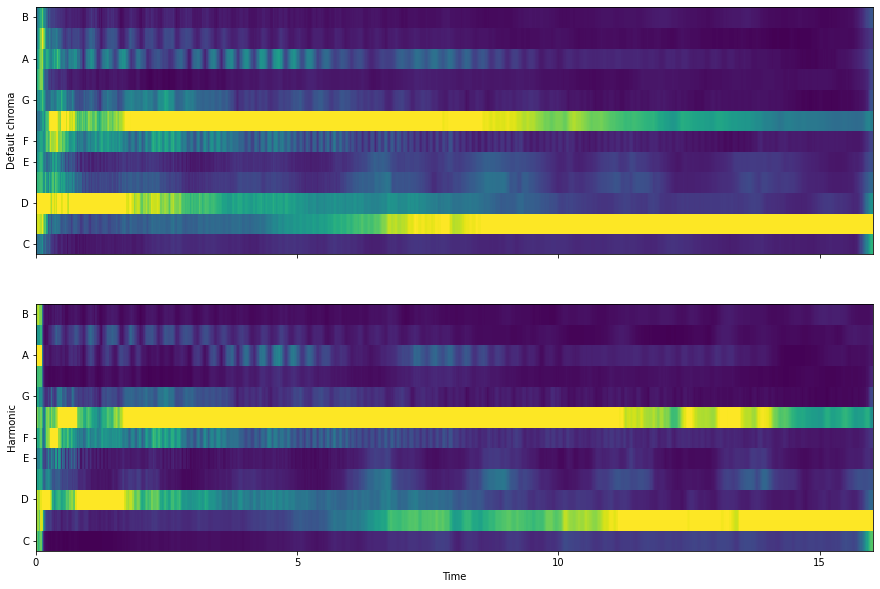

In [11]:
signal_harm = librosa.effects.harmonic(y=signal, margin=8)
chroma_harm = librosa.feature.chroma_cqt(y=signal_harm, sr=sr)


fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15, 10))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0], cmap='viridis')
ax[0].set(ylabel='Default chroma')
ax[0].label_outer()

librosa.display.specshow(chroma_harm, y_axis='chroma', x_axis='time', ax=ax[1], cmap='viridis')
ax[1].set(ylabel='Harmonic')

### Using non-local filtering to remove any sparse additive noise from the features

Secondly, we can clean up the noise using non-local filtering to effectively remove any sparse additive noise from the features.

[Text(0, 0.5, 'Non-local')]

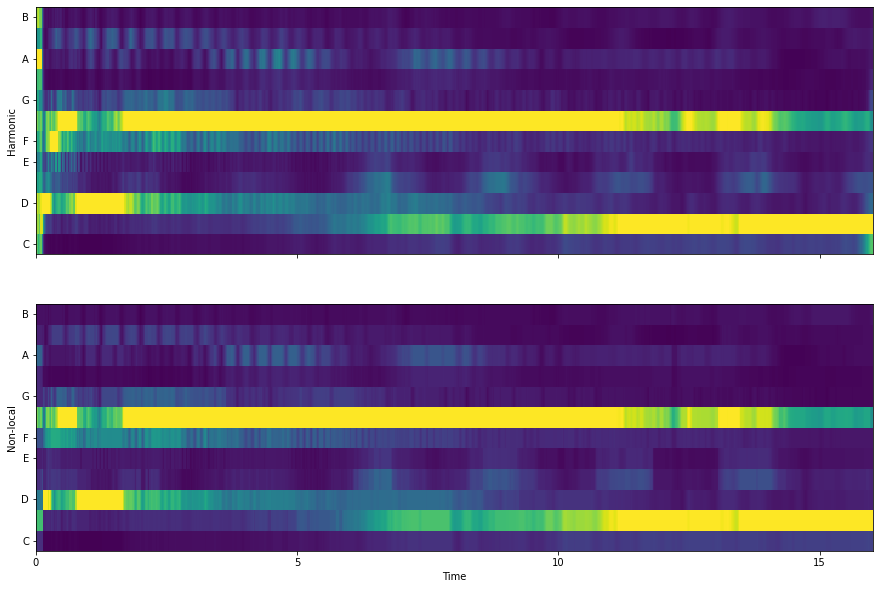

In [12]:
chroma_filter = np.minimum(chroma_harm, librosa.decompose.nn_filter(chroma_harm, aggregate=np.median, metric='cosine'))

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15, 10))
librosa.display.specshow(chroma_harm, y_axis='chroma', x_axis='time', ax=ax[0], cmap='viridis')
ax[0].set(ylabel='Harmonic')
ax[0].label_outer()

librosa.display.specshow(chroma_filter, y_axis='chroma', x_axis='time', ax=ax[1], cmap='viridis')
ax[1].set(ylabel='Non-local')

### Using horizontal median filter to delete local discontinuities and transients

Thirdly, we can suppress local discontinuities and transients using a horizontal median filter.

[Text(0, 0.5, 'Median-filtered')]

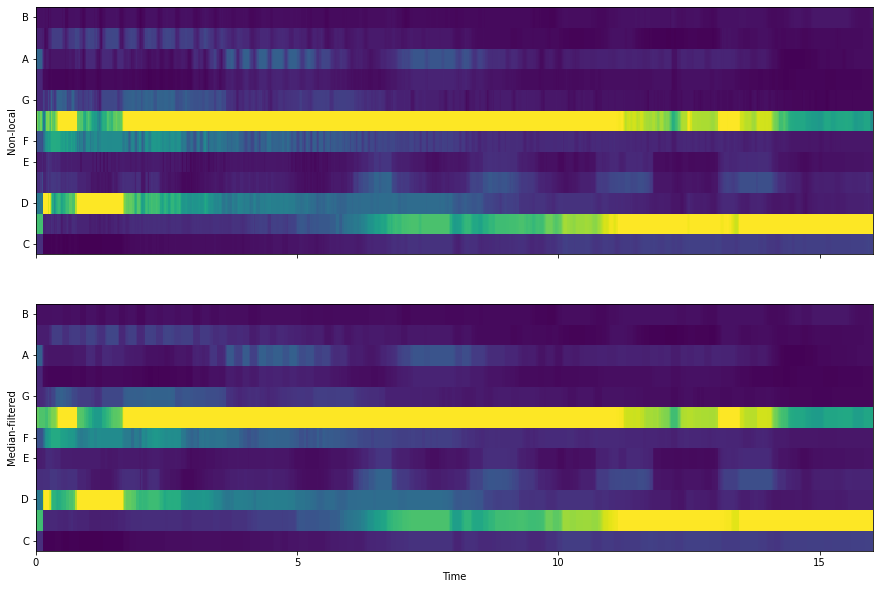

In [13]:
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))


fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15, 10))
librosa.display.specshow(chroma_filter, y_axis='chroma', x_axis='time', ax=ax[0], cmap='viridis')
ax[0].set(ylabel='Non-local')
ax[0].label_outer()

librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='time', ax=ax[1], cmap='viridis')
ax[1].set(ylabel='Median-filtered')

Finally, we can make a final comparison between the **Constant-Q Transform**, the **original chromagram** and the **result of our filtering**. This shows the three characteristic notes of the bell *Marie*, that are : (1) a **C#3 note** corresponding to the **hum note**, (2) a **F#4 note** corresponding to the **fundamental note** and (3) a **D5 note** corresponding to a poorly tuned fifth.

C:\Users\joachim\anaconda3\envs\sound\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


[Text(0, 0.5, 'Processed')]

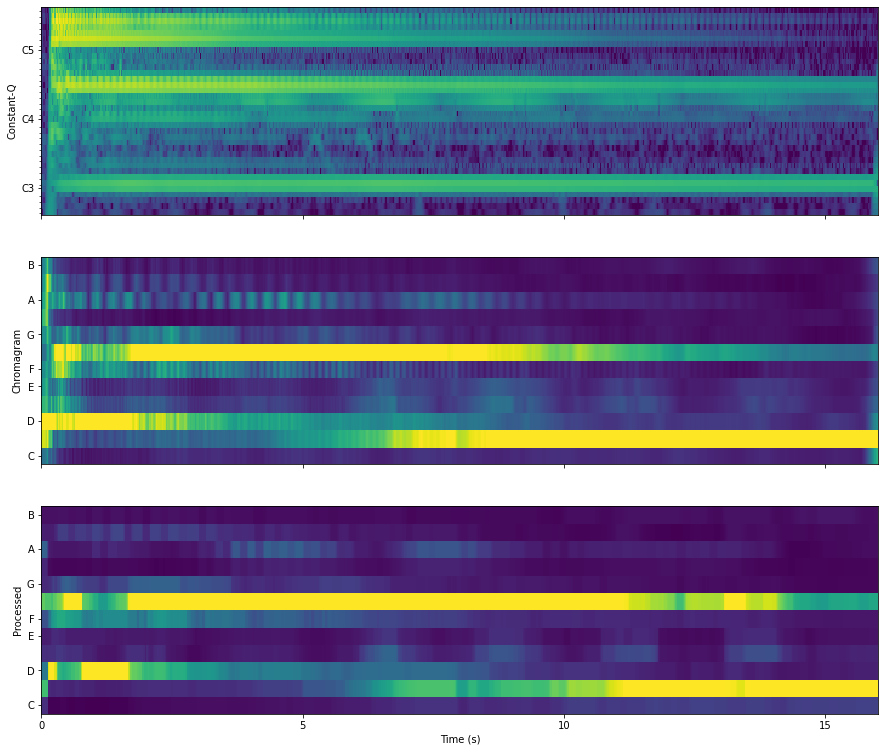

In [14]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(15, 13))
librosa.display.specshow(CQT_db, y_axis='cqt_note', x_axis='s', ax=ax[0], cmap='viridis')
ax[0].set(ylabel='Constant-Q')
ax[0].label_outer()
ax[0].axis([0, 30, 100, 800])

librosa.display.specshow(chroma, y_axis='chroma', x_axis='s', ax=ax[1], cmap='viridis')
ax[1].set(ylabel='Chromagram')
ax[1].label_outer()

librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='s', ax=ax[2], cmap='viridis')
ax[2].set(ylabel='Processed')